In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
from scipy.stats import beta
import pandas as pd
import pymc3 as pm

from dask.distributed import Client, LocalCluster
import dask.delayed

import logging

# Generating Our Data

In [3]:
num_users = 10000
sessions_per_user = np.random.geometric(0.5, size=num_users)
spu = pd.DataFrame({'spu': sessions_per_user})
print('Average sessions per user', np.sum(sessions_per_user)/num_users)
spu.spu.value_counts() / num_users

Average sessions per user 2.0018


1     0.4996
2     0.2503
3     0.1246
4     0.0646
5     0.0308
6     0.0141
7     0.0070
8     0.0044
9     0.0026
12    0.0005
11    0.0005
10    0.0005
13    0.0003
14    0.0002
Name: spu, dtype: float64

In [4]:
num_users = 10000
sessions_per_user = np.random.geometric(0.8, size=num_users)
spu = pd.DataFrame({'spu': sessions_per_user})
print('Average sessions per user', np.sum(sessions_per_user)/num_users)
spu.spu.value_counts() / num_users

Average sessions per user 1.2499


1    0.7987
2    0.1627
3    0.0305
4    0.0063
5    0.0017
6    0.0001
Name: spu, dtype: float64

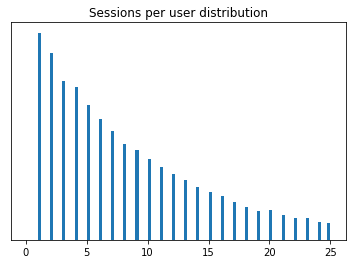

In [5]:
num_users = 30000

sessions_per_user = np.random.geometric(0.1, size=num_users)

# each user has some baseline conversion rate, we'll say ~2%
# baseline_conversion_rates = np.random.beta(2, 98, size=num_users);
baseline_conversion_rates = np.random.beta(20, 980, size=num_users);

# each user will experience a conversion uplift of 10% relative, so 0.2% or 20bps (absolute)
# larger sample size to emphasize confidence in 20 bps effect size for the sake of demonstration
conversion_uplifts = np.random.beta(200, 99800, size=num_users);


# plt.hist(conversion_uplifts, bins=100);
# 0 for control, 1 for treatment
# assignments = np.random.randint(0, 2, size=num_users);
# print(sessions_per_user)
plt.hist(sessions_per_user, bins=100, range=(0, 25), density=True);
plt.title('Sessions per user distribution');
frame1 = plt.gca();
# frame1.axes.xaxis.set_ticklabels([])
# frame1.axes.yaxis.set_ticklabels([]);
frame1.axes.get_yaxis().set_visible(False);


# plt.hist(sessions_per_user, bins=100);

# plt.hist(conversion_uplifts*100*100, bins=100, label='Conversion uplift bps');

# Session conversion dependent on SPU

In [5]:
sessions_per_user = np.random.geometric(0.1, size=num_users)

rates = 0.1*2/3 + 0.1*1/3*np.exp(-0.4*sessions_per_user)
a = rates*1000
b = 1000 - rates*1000
baseline_conversion_rates = np.random.beta(a, b, size=num_users);

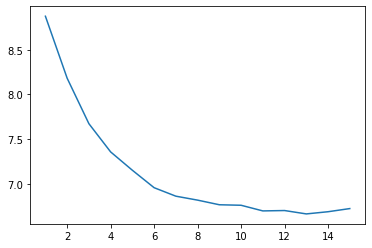

In [6]:
df = pd.DataFrame({'spu': sessions_per_user, 'cv': baseline_conversion_rates*100})
gdf = df.groupby('spu').cv.mean().reset_index(name='mean_cv')
plt.plot(gdf[gdf.spu <= 15].spu, gdf[gdf.spu <= 15].mean_cv);

In [7]:
num_users = 500000

sessions_per_user = np.random.geometric(0.5, size=num_users)
avg_conversion_rate = 0.1
rates = avg_conversion_rate*2/3 + avg_conversion_rate*1/3*np.exp(-0.4*sessions_per_user)
a = rates*1000
b = 1000 - rates*1000
conversion_rates = np.random.beta(a, b, size=num_users);

In [8]:
data = {
    'user': [],
    'session_id': [],
    'session_converted': []
}

for user_id, num_sessions in enumerate(sessions_per_user):
    for session_id in range(1, num_sessions+1):
        conversion_rate = conversion_rates[user_id]
        session_converted = np.random.choice([0, 1], p=[1-conversion_rate, conversion_rate])
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['session_converted'].append(session_converted)

In [9]:
df = pd.DataFrame(data)

In [13]:
udf = (
    df
    .groupby('user')
    .agg(
        total_sessions=('session_converted', 'count'),
        num_converted=('session_converted', 'sum'),
    ).reset_index()
)

In [10]:
cluster = LocalCluster(
    n_workers=12, 
    threads_per_worker=1, 
    processes=True, 
    silence_logs=logging.ERROR
)
client = Client(cluster)
client

# client.shutdown()
# client.close()

Client Scheduler: tcp://127.0.0.1:57092 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 34.36 GB


In [15]:
# 1) randomly select 50,000 users, calculate session conversion rate
# 2) repeat 10,000 times

def simulate_user_randomization(scattered_df):
    sampled_users = scattered_df.sample(50000, replace=False)
    total_sessions = sampled_users['total_sessions'].sum()
    total_converted = sampled_users['num_converted'].sum()
    return {
        'total_sessions': total_sessions, 
        'session_conversion_rate': total_converted/total_sessions
    }

scattered_df = client.scatter(udf)
delayed_user_randomization_results = []
for x in range(0, 10000):
    result = dask.delayed(simulate_user_randomization)(scattered_df)
    delayed_user_randomization_results.append(result)

user_randomization_results = dask.compute(*delayed_user_randomization_results)

In [16]:
print(np.mean([x['session_conversion_rate'] for x in user_randomization_results]))
print(np.mean([x['total_sessions'] for x in user_randomization_results]))

0.07942715604049272
100210.4831


In [20]:
# see how many sessions you got, on average, in :point-up:
# 1) randomly select X sessions, calculate session conversion rate
# 2) repeat 10,000 times
avg_num_sessions = int(np.mean([x['total_sessions'] for x in user_randomization_results]))


def simulate_session_randomization(scattered_df):
    sampled_sessions = scattered_df.sample(avg_num_sessions, replace=False)
    total_sessions = sampled_sessions['session_converted'].count()
    total_converted = sampled_sessions['session_converted'].sum()    
    return {
        'total_sessions': total_sessions, 
        'session_conversion_rate': total_converted/total_sessions
    }
    
scattered_df = client.scatter(df)
delayed_session_randomization_results = []
for x in range(0, 10000):
    result = dask.delayed(simulate_session_randomization)(scattered_df)
    delayed_session_randomization_results.append(result)

session_randomization_results = dask.compute(*delayed_session_randomization_results)

In [21]:
print(np.mean([x['session_conversion_rate'] for x in session_randomization_results]))
print(np.mean([x['total_sessions'] for x in session_randomization_results]))

0.07942780760403155
100210.0


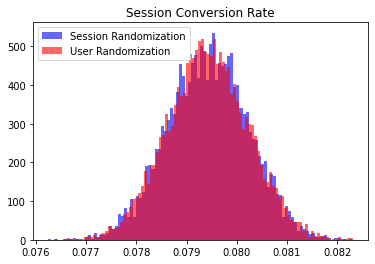

In [26]:
sl = [x['session_conversion_rate'] for x in session_randomization_results]
ul = [x['session_conversion_rate'] for x in user_randomization_results]

plt.title('Session Conversion Rate')
plt.hist(sl, bins=100, density=True, alpha=0.6, color='b', label='Session Randomization');
plt.hist(ul, bins=100, density=True, alpha=0.6, color='r', label='User Randomization');
plt.legend();

# Simulating Session Level Randomization

In [71]:
num_users = 10000

sessions_per_user = np.random.geometric(0.5, size=num_users)

# each user has some baseline conversion rate, we'll say ~25%
baseline_conversion_rates = np.random.beta(250, 750, size=num_users);

# +5% boost  (20% relative)
conversion_uplifts = np.random.beta(50, 950, size=num_users);


# session level randomization
data = {
    'user': [],
    'session_id': [],
    'assignment': [],
    'session_converted': []
}

i = 0
for user_id, num_sessions in enumerate(sessions_per_user):
    for session_id in range(1, num_sessions+1):
        assignment = np.random.randint(0, 2)
#         assignment = assignments[i]
        new_conversion_rate = baseline_conversion_rates[user_id] + assignment*conversion_uplifts[user_id]
        session_converted = np.random.choice([0, 1], p=[1-new_conversion_rate, new_conversion_rate])
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['assignment'].append(assignment)
        data['session_converted'].append(session_converted)
        i += 1

In [72]:
df = pd.DataFrame(data)
print (f"Average sessions per user: {df.shape[0] / len(df.user.unique()):0.3f}")
df

Average sessions per user: 2.005


,user,session_id,assignment,session_converted
0,0,0-1,0,0
1,0,0-2,0,0
2,1,1-1,0,1
3,1,1-2,0,0
4,2,2-1,0,0
...,...,...,...,...
20043,9998,9998-1,0,0
20044,9998,9998-2,0,0
20045,9998,9998-3,0,0
20046,9999,9999-1,0,0


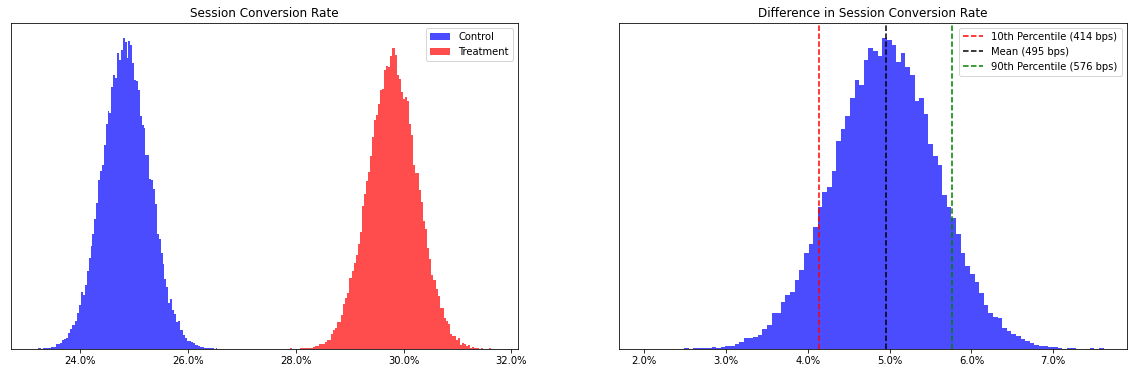

In [73]:
num_samples = 50000

control_converted = df[df.assignment==0].session_converted.sum()
control_total = df[df.assignment==0].session_converted.count()
control_samples = np.random.beta(control_converted, control_total - control_converted, size=num_samples)


test_converted = df[df.assignment==1].session_converted.sum()
test_total = df[df.assignment==1].session_converted.count()
test_samples = np.random.beta(test_converted, test_total - test_converted, size=num_samples)


fig, axs = plt.subplots(1, 2, figsize=(20, 6));
axs[0].hist(control_samples, density=True, bins=100, alpha=0.7, color='b', label='Control');
axs[0].hist(test_samples, density=True, bins=100, alpha=0.7, color='r', label='Treatment');
axs[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
axs[0].set_title('Session Conversion Rate');
axs[0].get_yaxis().set_visible(False);
axs[0].legend();


diffs = test_samples - control_samples
p10_diff = np.percentile(diffs, 10)
p90_diff = np.percentile(diffs, 90)
mean_diff = np.mean(diffs)
axs[1].hist(diffs, density=True, bins=100, alpha=0.7, color='b');
axs[1].axvline(p10_diff, color='r', linestyle='dashed', label=f'10th Percentile ({p10_diff*100*100:0.0f} bps)');
axs[1].axvline(mean_diff, color='k', linestyle='dashed', label=f'Mean ({mean_diff*100*100:0.0f} bps)');
axs[1].axvline(p90_diff, color='g', linestyle='dashed', label=f'90th Percentile ({p90_diff*100*100:0.0f} bps)');
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
axs[1].set_title('Difference in Session Conversion Rate');
axs[1].get_yaxis().set_visible(False);
axs[1].legend();

In [74]:
df.groupby('assignment').session_converted.mean()*100

assignment
0    24.847148
1    29.798431
Name: session_converted, dtype: float64

# Simulations with Dask

In [94]:
cluster = LocalCluster(
    n_workers=12, 
    threads_per_worker=1, 
    processes=True, 
    silence_logs=logging.ERROR
)
client = Client(cluster)
client

# client.shutdown()
# client.close()

In [78]:
def calculate_metrics(data, metric):

    df = pd.DataFrame(data)
    num_samples = 50000
    
    if metric == 'user':
        df = df.groupby(['user', 'assignment']).agg(converted=('session_converted', 'max')).reset_index()
    elif metric == 'session':
        df['converted'] = df['session_converted']
    else:
        raise NotImplementedError("metric must be 'user' or 'session'")    

    control_converted = df[df.assignment==0].converted.sum()
    control_total = df[df.assignment==0].converted.count()
    control_samples = np.random.beta(control_converted, control_total - control_converted, size=num_samples)

    test_converted = df[df.assignment==1].converted.sum()
    test_total = df[df.assignment==1].converted.count()
    test_samples = np.random.beta(test_converted, test_total - test_converted, size=num_samples)

    # how often does test convert higher than the control?
    test_gt_control = (test_samples > control_samples).mean()
    # in what range do we think the true conversion rates lie?
    test_interval = [np.percentile(test_samples, 10), np.percentile(test_samples, 90)]
    control_interval = [np.percentile(control_samples, 10), np.percentile(control_samples, 90)]
    
    # how much better is test than control?
    diffs = test_samples - control_samples
    diff_interval = [np.percentile(diffs, 10), np.percentile(diffs, 90)]
    mean_diff = np.mean(diffs)
    
    return {
        'test_gt_control': test_gt_control,
        'test_interval': test_interval,
        'control_interval': control_interval,
        'diff_interval': diff_interval,
        'mean_diff': mean_diff
        
    }
        
def run_simulation(
        num_users=30000, 
        baseline_conversion=0.1, 
        relative_uplift=0.1, 
        is_aa_test=False,
        randomization_unit='session',
        persist_treatment_effect=False,
        geometric_p=0.5,
    ):

    if randomization_unit not in ['session', 'user']:
        raise NotImplementedError("randomization_unit must be 'session' or 'user'")
    
    # sessions per user
    sessions_per_user = np.random.geometric(geometric_p, size=num_users)

    # each user has some baseline conversion rate
    a = baseline_conversion*1000
    b = 1000 - a
    baseline_conversion_rates = np.random.beta(a, b, size=num_users);

    if is_aa_test:
        conversion_uplifts = np.zeros(shape=num_users)
    else:
        # each user will experience a conversion uplift of 10% relative, so 0.2% or 20bps (absolute)
        # larger sample size to emphasize confidence in 20 bps effect size for the sake of demonstration
        a = baseline_conversion*relative_uplift*10000
        b = 10000 - a
        conversion_uplifts = np.random.beta(a, b, size=num_users);

    # session level randomization
    data = {
        'user': [],
        'session_id': [],
        'assignment': [],
        'session_converted': []
    }

    conversion_rates = baseline_conversion_rates.copy()

    for user_id, num_sessions in enumerate(sessions_per_user):
        if randomization_unit == 'user':
            assignment = np.random.randint(0, 2)
            
        for session_id in range(1, num_sessions+1):
            if randomization_unit == 'session':
                assignment = np.random.randint(0, 2)
            
            if assignment == 1 and persist_treatment_effect:
                # increase user conversion rate permanently
                conversion_rates[user_id] = baseline_conversion_rates[user_id] + conversion_uplifts[user_id]
                user_conversion_rate = conversion_rates[user_id]
            elif assignment == 1:
                # temporarily increase conversion rate for given session
                user_conversion_rate = baseline_conversion_rates[user_id] + conversion_uplifts[user_id]
            else:
                user_conversion_rate = conversion_rates[user_id]
            
            session_converted = np.random.choice([0, 1], p=[1-user_conversion_rate, user_conversion_rate])
            data['user'].append(user_id)
            data['session_id'].append(f"{user_id}-{session_id}")
            data['assignment'].append(assignment)
            data['session_converted'].append(session_converted)

    # now do bayesian analysis with our observered results
    return {
        'session_conversion': calculate_metrics(data, metric='session'),
        'user_conversion': calculate_metrics(data, metric='user'),
    }

In [79]:
run_simulation(randomization_unit='user')

{'session_conversion': {'test_gt_control': 0.99944,
  'test_interval': [0.10680756291951164, 0.11144704382202775],
  'control_interval': [0.09884384282709588, 0.1033109968878478],
  'diff_interval': [0.004854577409887412, 0.011270028913729326],
  'mean_diff': 0.008041107965523842},
 'user_conversion': {'test_gt_control': 0.99666,
  'test_interval': [0.19227095478449585, 0.2005945456082883],
  'control_interval': [0.18004726740753635, 0.18818681152331757],
  'diff_interval': [0.006514831090339713, 0.018151534331265828],
  'mean_diff': 0.012328731432653556}}

In [54]:
for dr in delayed_results:
    client.cancel(dr)

## A/B Test - Session Level Randomization

In [93]:
delayed_results = []

NUM_EXPERIMENTS = 250
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=10000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=False,
        randomization_unit='session',
        persist_treatment_effect=False,
        geometric_p=0.5,
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
    f"Average effect size detected: {avg_effect_size*100*100:0.0f} bps\n"
)

Detected positive effect 100.0% of the time
Average effect size detected: 201 bps



## A/B Test - Session Level Randomization with Effect Persistence

In [82]:
delayed_results = []

NUM_EXPERIMENTS = 250
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=10000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=False,
        randomization_unit='session',
        persist_treatment_effect=True,
        geometric_p=0.5,
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
    f"Average effect size detected: {avg_effect_size*100*100:0.0f} bps\n"
)

Detected positive effect 90.0% of the time
Average effect size detected: 137 bps



## A/B Test - User Level Randomization with Effect Persistence

In [83]:
delayed_results = []

NUM_EXPERIMENTS = 250
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=10000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=False,
        randomization_unit='user',
        persist_treatment_effect=True,
        geometric_p=0.5,
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
    f"Average effect size detected: {avg_effect_size*100*100:0.0f} bps\n"
)

Detected positive effect 100.0% of the time
Average effect size detected: 199 bps



## A/A Test - Session Level Randomization

In [80]:
delayed_results = []

NUM_EXPERIMENTS = 500
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=10000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=True,
        randomization_unit='session',
        persist_treatment_effect=False,
        geometric_p=0.5,
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
)

Detected positive effect 5.8% of the time



## A/A Test - User Level Randomization with Effect Persistence

In [85]:
delayed_results = []

NUM_EXPERIMENTS = 500
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(        
        num_users=10000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=True,
        randomization_unit='user',
        persist_treatment_effect=True,
        geometric_p=0.1,
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
)


Detected positive effect 6.4% of the time



In [56]:
# for dr in delayed_results:
#     client.cancel(dr)

# Graphing Sessions per User

In [86]:
num_users = 100000

# sessions per user in a 2 week period
sessions_per_user = np.random.geometric(0.1, size=num_users)

# each user has some baseline conversion rate, we'll say ~10%
baseline_conversion_rates = np.random.beta(100, 900, size=num_users);

# session level randomization
data = {
    'user': [],
    'session_id': [],
    'session_converted': []
}

for user_id, num_sessions in enumerate(sessions_per_user):
    for session_id in range(1, num_sessions+1):
        conversion_rate = baseline_conversion_rates[user_id]
        session_converted = np.random.choice([0, 1], p=[1-conversion_rate, conversion_rate])
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['session_converted'].append(session_converted)

In [87]:
df = pd.DataFrame(data)
gdf = (
    df
    .groupby('user')
    .agg(
        sessions_per_user=('session_converted', 'count'), 
        num_converted=('session_converted', 'sum'),
        converted=('session_converted', 'max'),
    )
    .reset_index()
)

gdf.head()

,user,sessions_per_user,num_converted,converted
0,0,9,1,1
1,1,24,2,1
2,2,7,0,0
3,3,4,0,0
4,4,5,1,1


In [88]:
spu_df = (
    gdf
    .groupby('sessions_per_user')
    .agg(
        total_sessions=('sessions_per_user', 'sum'),
        total_users=('user', 'count'),
        total_session_conversions=('num_converted', 'sum'),
        total_user_conversions=('converted', 'sum'),
    )
    .reset_index()
)


spu_df['session_conversion_rate'] = spu_df['total_session_conversions'] / spu_df['total_sessions']
spu_df['user_conversion_rate'] = spu_df['total_user_conversions'] / spu_df['total_users']

spu_df

,sessions_per_user,total_sessions,total_users,total_session_conversions,total_user_conversions,session_conversion_rate,user_conversion_rate
0,1,10017,10017,1018,1018,0.101627,0.101627
1,2,17938,8969,1761,1667,0.098171,0.185862
2,3,24282,8094,2490,2243,0.102545,0.277119
3,4,29112,7278,2926,2494,0.100508,0.342677
4,5,31700,6340,3184,2598,0.100442,0.409779
...,...,...,...,...,...,...,...
87,91,182,2,15,2,0.082418,1.000000
88,93,186,2,19,2,0.102151,1.000000
89,94,188,2,14,2,0.074468,1.000000
90,96,96,1,11,1,0.114583,1.000000


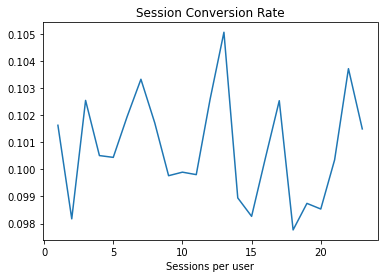

In [89]:
plt.plot(spu_df[spu_df.total_users>1000].sessions_per_user, spu_df[spu_df.total_users>1000].session_conversion_rate);
plt.xlabel('Sessions per user');
plt.title('Session Conversion Rate');

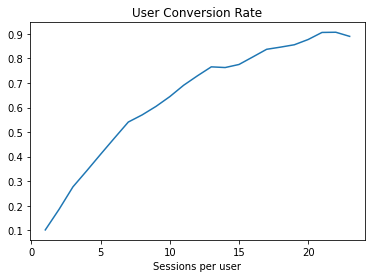

In [90]:
plt.plot(spu_df[spu_df.total_users>1000].sessions_per_user, spu_df[spu_df.total_users>1000].user_conversion_rate);
plt.xlabel('Sessions per user');
plt.title('User Conversion Rate');